# Description of the notebook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

This notebook presents one of the first implementations for the solution of the **Homework 1 of the course of Advanced neural networks and deep learning**.

The main network you can find in this notebook is a hand-crafted one.

```
# Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(units=128, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), name='dense')(x)

    output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)
```

This network has been trained with a 80-20 % division between training and validation set.

The dataset has been cleaned from the obvious outliers present before the splitting.

No weight balancing has been performed. No regularization has been introduced.

# Import libraries

In [1]:
#Connect to drive
from google.colab import drive

In [2]:
from numpy import load
import numpy as np
from google.colab.patches import cv2_imshow

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [5]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Loading dataset


In [6]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ANNDL/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/ANNDL/Homework 1


In [7]:
#load data
data = load('public_data.npz', allow_pickle=True)
lst = data.files

In [8]:
#Divide the dataset in image set and label set
img_set = data['data']
label_set = data['labels']


#Inspect Data

In [9]:
#Inspect the shape and the type
print(data['data'][0].shape)
print(type(data['data'][0]))

(96, 96, 3)
<class 'numpy.ndarray'>


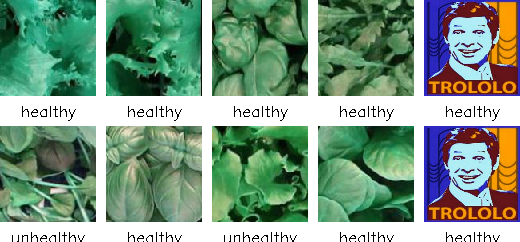

In [10]:
# Assuming you have a list of images in img_set and their corresponding labels in label_set
num_images = len(img_set)
num_to_display = 10

# Set the spacing between images and labels
vertical_spacing = 10
horizontal_spacing = 10

# Calculate the canvas size based on image and label dimensions
max_image_height = max(img.shape[0] for img in img_set)
image_width = img_set[0].shape[1]
label_height = 20
canvas_height = 2 * (max_image_height + label_height) + vertical_spacing
canvas_width = 5 * image_width + 4 * horizontal_spacing

# Create a white canvas to display the images and labels on
canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255

# Select 10 random indices to display
random_indices = random.sample(range(num_images), num_to_display)

# Arrange and display the images and labels with spacing
for i, index in enumerate(random_indices):
    row = i // 5
    col = i % 5
    y_offset = row * (max_image_height + label_height + vertical_spacing)
    x_offset = col * (image_width + horizontal_spacing)

    # Place the image on the canvas
    img = img_set[index]
    canvas[y_offset:y_offset + img.shape[0], x_offset:x_offset + image_width, :] = img

    # Display the label above the image
    label_text = label_set[index]  # Get the label text from label_set
    label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x_offset + (image_width - label_size[0]) // 2
    label_y = y_offset + img.shape[0] + label_height
    cv2.putText(canvas, label_text, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

cv2_imshow(canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Data Cleaning

## Shrek

In [11]:
# Select the reference image 'shrek' from the image set
shrek = img_set[58]

# list of images to remove
indexes_to_remove = []
for i in range(0, len(img_set)):
    if np.array_equal(shrek, img_set[i]):
        indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [58, 95, 137, 138, 171, 207, 506, 571, 599, 622, 658, 692, 779, 827, 840, 880, 901, 974, 1028, 1265, 1268, 1280, 1333, 1443, 1466, 1483, 1528, 1554, 1594, 1651, 1806, 1866, 1938, 1977, 2022, 2081, 2090, 2261, 2311, 2328, 2380, 2435, 2451, 2453, 2515, 2663, 2665, 2675, 2727, 2734, 2736, 2755, 2779, 2800, 2830, 2864, 2866, 2913, 2937, 3033, 3055, 3105, 3144, 3155, 3286, 3410, 3488, 3572, 3583, 3666, 3688, 3770, 3801, 3802, 3806, 3811, 3862, 3885, 3927, 3931, 3946, 3988, 4097, 4118, 4144, 4150, 4282, 4368, 4475, 4476, 4507, 4694, 4740, 4779, 4857, 5082, 5121, 5171]
Number of indexes to remove: 98


In [12]:
print("Length before removing Shrek: ", len(img_set))

img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Shrek: ", len(img_set))

Length before removing Shrek:  5200
Length after removing Shrek:  5102


## Trololo

In [13]:
# Select the reference image 'trololo' from the image set
trololo = img_set[332]  # Note: It is 332 AFTER removing 'Shrek'

indexes_to_remove = []

# Iterate through the image set to identify occurrences of 'trololo' and remove
for i in range(0, len(img_set)):
    if np.array_equal(trololo, img_set[i]):
         indexes_to_remove.append(i)

print("Indexes to remove:", indexes_to_remove)
print("Number of indexes to remove:", len(indexes_to_remove))

Indexes to remove: [332, 406, 428, 480, 522, 689, 711, 713, 741, 770, 882, 944, 954, 971, 1025, 1045, 1046, 1082, 1130, 1153, 1171, 1172, 1361, 1514, 1580, 1601, 1660, 1667, 1722, 1727, 1729, 1797, 1871, 1906, 1947, 1954, 2113, 2154, 2155, 2161, 2308, 2385, 2443, 2452, 2519, 2536, 2548, 2551, 2628, 2743, 2776, 2784, 2832, 2871, 2989, 3025, 3046, 3311, 3370, 3385, 3423, 3629, 3669, 3728, 3745, 3759, 3818, 3821, 3826, 3869, 3883, 3907, 3967, 3973, 4017, 4223, 4227, 4229, 4323, 4413, 4466, 4514, 4527, 4627, 4643, 4673, 4743, 4754, 4765, 4788, 4802, 4808, 4812, 4832, 4953, 4985, 5046, 5068]
Number of indexes to remove: 98


In [14]:
print("Length before removing Trololo: ", len(img_set))

img_set = img_set[~np.isin(np.arange(len(img_set)), indexes_to_remove)]
label_set = label_set[~np.isin(np.arange(len(label_set)), indexes_to_remove)]

print("Length after removing Trololo: ", len(img_set))

Length before removing Trololo:  5102
Length after removing Trololo:  5004


# Distributions

In [15]:
# Create a list of unique classes in your label set
unique_classes = np.unique(label_set)
# Count the occurrences of each class
class_counts = [np.sum(label_set == c) for c in unique_classes]
# Set the number of bins for your histogram
n_bins = len(unique_classes)
# Set the bar width and the separation between bars
bar_width = 0.4
bar_spacing = 0.2
x_positions = np.arange(len(unique_classes))
# Create a color map for the bars
colors = ['green', 'brown']

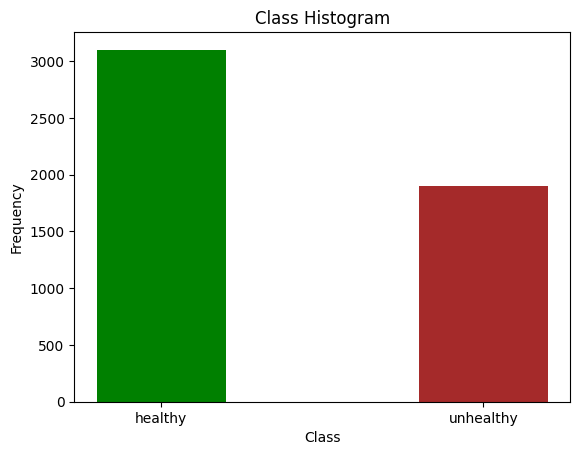

In [16]:
# Plot the histogram with colored bars and adjusted spacing
plt.bar(x_positions, class_counts, width=bar_width, color=colors)
plt.xticks(x_positions, unique_classes)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Histogram')
plt.show()

# Image Augmentation

## Function for displaying the transformations

In [17]:
def display_transformation(img_set,X_train_flip):
  # Assuming you have two sets of images in img_set1 and img_set2
  num_images = len(img_set)
  num_to_display = 5

  # Set the spacing between images and labels
  vertical_spacing = 10
  horizontal_spacing = 10

  # Calculate the canvas size based on image dimensions
  max_image_height = max(img.shape[0] for img in img_set)
  image_width = img_set[0].shape[1]
  label_height = 20
  canvas_height = 2 * (max_image_height + label_height) + vertical_spacing
  canvas_width = 5 * image_width + 4 * horizontal_spacing

  # Create a white canvas to display the images and labels on
  canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255

  # Select 5 random indices to display from each set
  random_indices_set = random.sample(range(num_images), num_to_display)

    # Arrange and display the images and labels with spacing
  for i in range(num_to_display):
      # Place the image from the first set on the first row
      img1 = img_set[random_indices_set[i]]
      y_offset = 0
      x_offset = i * (image_width + horizontal_spacing)
      canvas[y_offset:y_offset + img1.shape[0], x_offset:x_offset + image_width, :] = img1

      # Place the image from the second set on the second row
      img2 = X_train_flip[random_indices_set[i]]
      y_offset = max_image_height + label_height + vertical_spacing
      x_offset = i * (image_width + horizontal_spacing)
      canvas[y_offset:y_offset + img2.shape[0], x_offset:x_offset + image_width, :] = img2

      # Display the label above the image
      label_text = label_set[i]  # Get the label text from label_set
      label_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
      label_x = x_offset + (image_width - label_size[0]) // 2
      label_y = y_offset + img.shape[0] + label_height
      cv2.putText(canvas, label_text, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

  cv2_imshow(canvas)
  cv2.waitKey(0)
  cv2.destroyAllWindows()


## Horizontal Flip

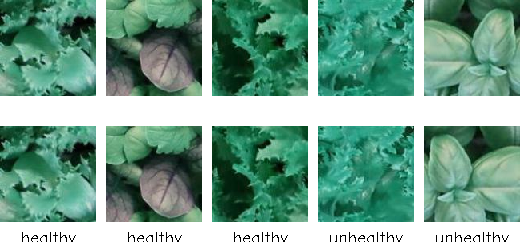

In [18]:
#RandomFlip - Horizontal
flip = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal"),
])

X_train_flip = flip(img_set)
display_transformation(img_set,X_train_flip)

## Random Translation

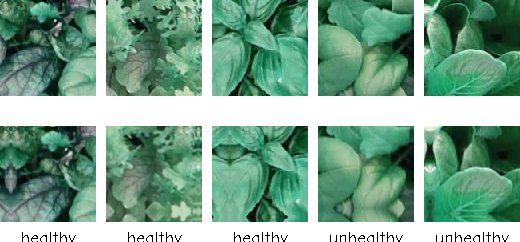

In [19]:
translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

X_train_translation = translation(img_set)
display_transformation(img_set,X_train_translation)

##Random Rotation

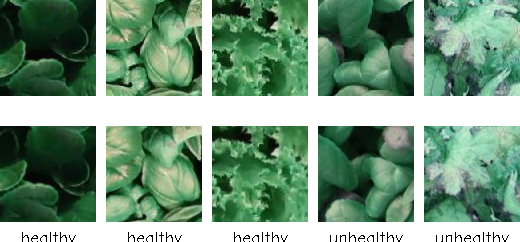

In [20]:
rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

X_train_rotation = rotation(img_set)
display_transformation(img_set,X_train_rotation)

##Random Zoom

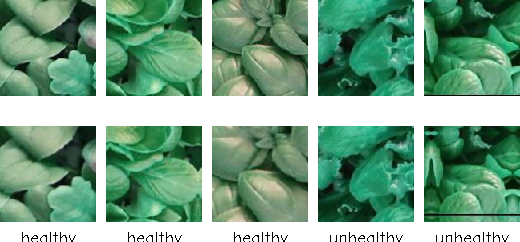

In [21]:
zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

X_train_zoom = zoom(img_set)
display_transformation(img_set,X_train_zoom)

#Build the model

##Convert to categorical data

In [22]:
# Define a mapping from label strings to numerical values
labels_string_to_num = {'healthy': 0, 'unhealthy': 1}

# Iterate through the label_set and replace label strings with their corresponding numerical values
for i in range(0, len(label_set)):
    label_set[i] = labels_string_to_num[label_set[i]]

# Expand the label_set to have an additional dimension
label_num = np.expand_dims(label_set, axis=-1)

print("Label shape: ", label_num.shape)

# Convert numerical labels to one-hot encoded categorical labels
label_cat = tfk.utils.to_categorical(label_num, num_classes=2)

print("Example of categorical label: ", label_cat[0])

Label shape:  (5004, 1)
Example of categorical label:  [1. 0.]


##Spilt the dataset

In [23]:
# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(img_set, label_cat, random_state=seed, test_size=.20, stratify=np.argmax(label_cat, axis=1))

In [24]:
# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')

In [25]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4003, 96, 96, 3), y_train shape: (4003, 2)
X_val shape: (1001, 96, 96, 3), y_val shape: (1001, 2)


##Imbalanced dataset

Class weight Method

In [26]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# Calculate the number of samples with label 0 (healthy) and label 1 (unhealthy)
num_healthy = np.count_nonzero(label_set == 0)
num_unhealthy = np.count_nonzero(label_set == 1)

# Calculate the total number of samples
total = num_healthy + num_unhealthy

# Calculate class weights for binary classification
# Class weight for 0 (healthy) is calculated based on the imbalance in the dataset
# Weight for class 0 is scaled to help keep the loss to a similar magnitude, ensuring that the sum of weights stays the same.
weight_for_0 = (1 / num_healthy) * (total / 2.0)
# Class weight for 1 (unhealthy) is similarly calculated, maintaining the same total weight.
weight_for_1 = (1 / num_unhealthy) * (total / 2.0)

# Create a dictionary that maps class labels to their corresponding class weights
class_weight = {0: weight_for_0, 1: weight_for_1}

# Print the calculated class weights for class 0 and class 1
print('Weight for class 0 (healthy): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (unhealthy): {:.2f}'.format(weight_for_1))

Weight for class 0 (healthy): 0.81
Weight for class 1 (unhealthy): 1.31


##Model

In [27]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 32
epochs = 300

In [28]:
def build_model_with_augmentation(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(units=128, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), name='dense')(x)

    output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate = 0.001, weight_decay=5e-5), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

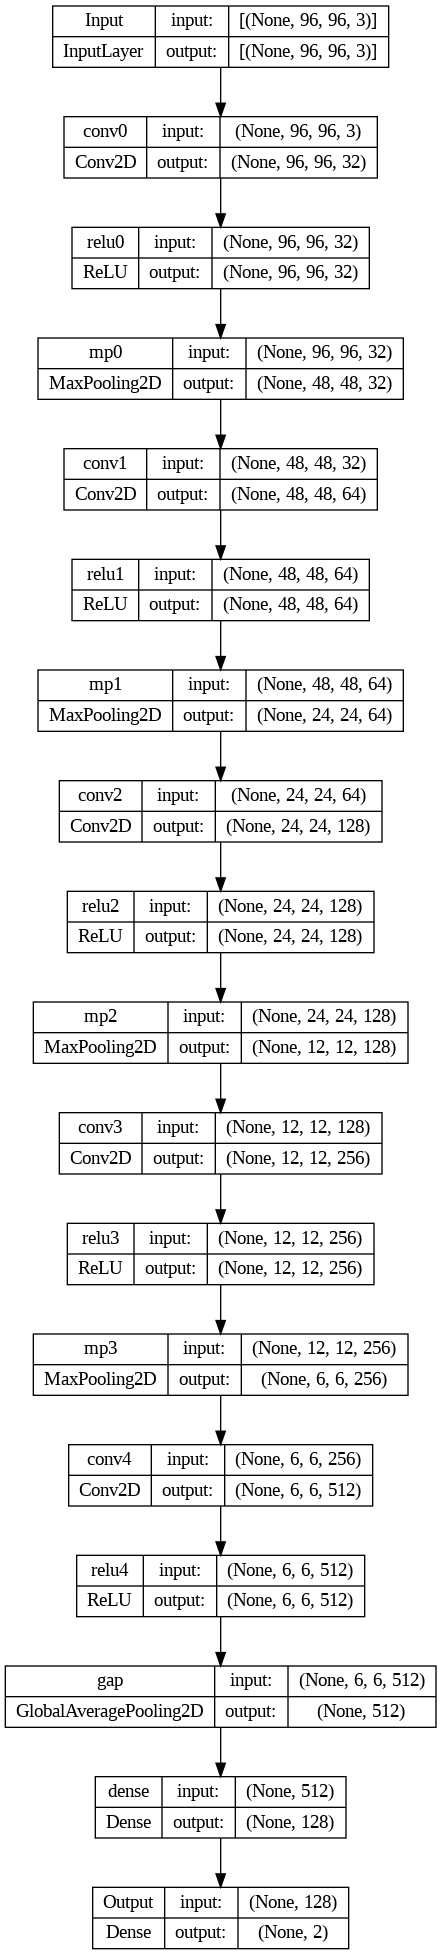

In [29]:
augmented_model = build_model_with_augmentation()
augmented_model.summary()
tfk.utils.plot_model(augmented_model, expand_nested=True, show_shapes=True)

#Train the model

In [30]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='auto'),
]

# Train the model
aug_history = augmented_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks,
    class_weight=class_weight
).history

Epoch 1/300
126/126 [==============================] - 9s 29ms/step - loss: 0.6942 - accuracy: 0.4292 - val_loss: 0.6920 - val_accuracy: 0.6194
Epoch 2/300
126/126 [==============================] - 2s 18ms/step - loss: 0.6933 - accuracy: 0.4609 - val_loss: 0.6918 - val_accuracy: 0.6194
Epoch 3/300
126/126 [==============================] - 2s 16ms/step - loss: 0.6933 - accuracy: 0.5791 - val_loss: 0.6932 - val_accuracy: 0.3806
Epoch 4/300
126/126 [==============================] - 2s 16ms/step - loss: 0.6932 - accuracy: 0.4861 - val_loss: 0.6938 - val_accuracy: 0.3806
Epoch 5/300
126/126 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.6003 - val_loss: 0.6931 - val_accuracy: 0.6194
Epoch 6/300
126/126 [==============================] - 2s 17ms/step - loss: 0.6932 - accuracy: 0.3822 - val_loss: 0.6937 - val_accuracy: 0.3806
Epoch 7/300
126/126 [==============================] - 2s 18ms/step - loss: 0.6882 - accuracy: 0.5011 - val_loss: 0.6548 - val_accuracy:

## Plots of the Categorical CrossEntropy and Accuracy

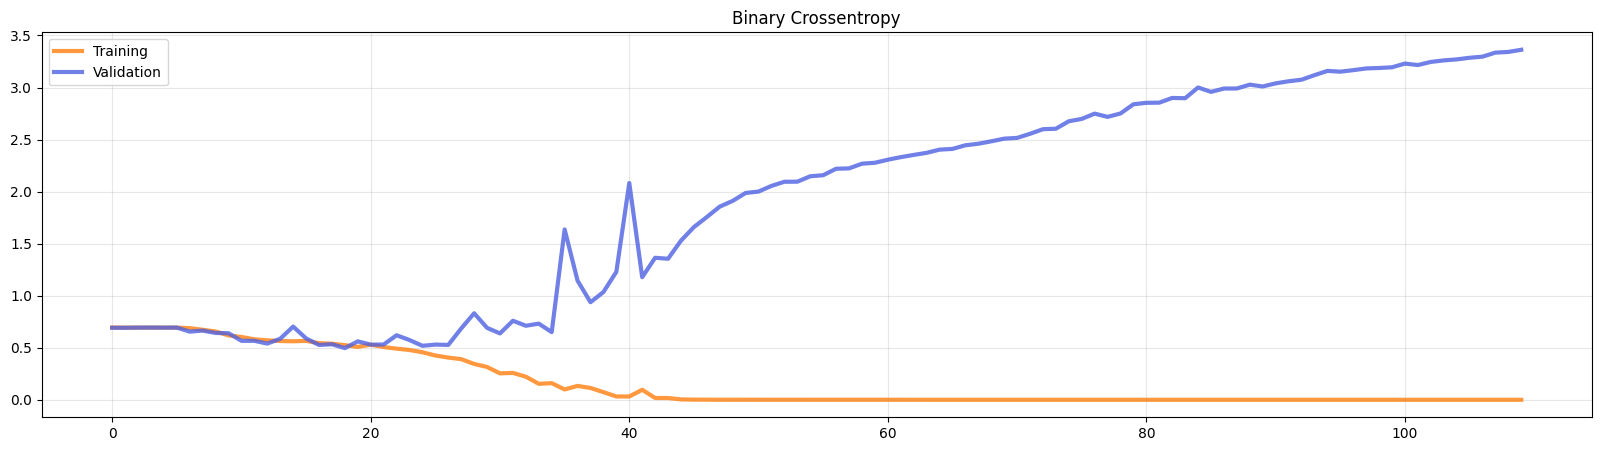

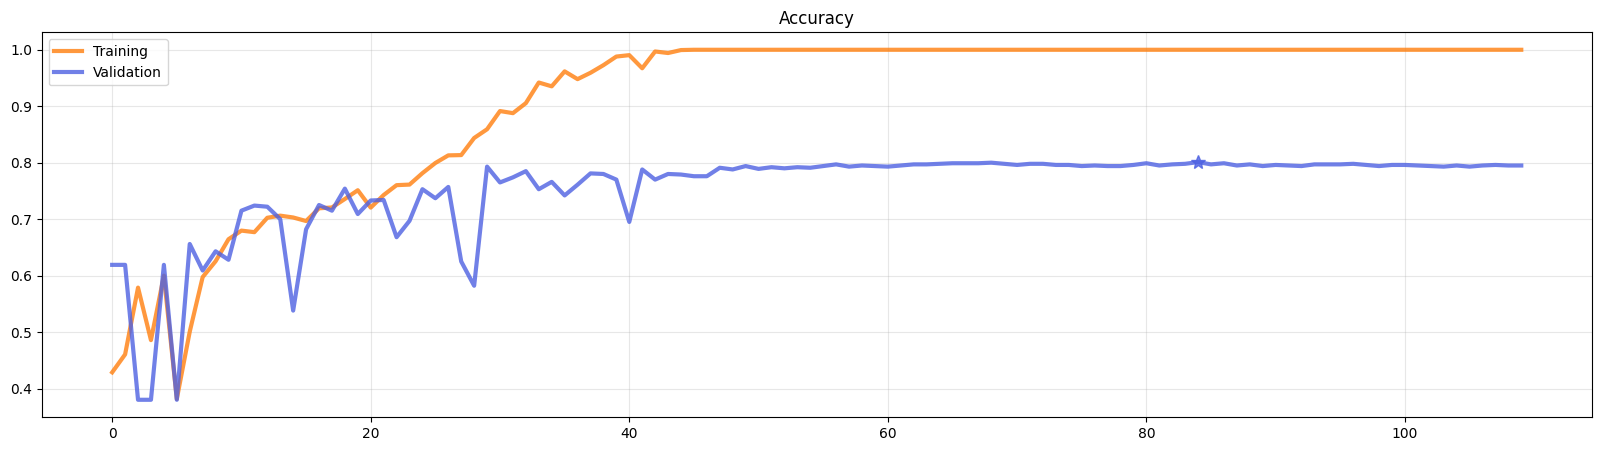

In [31]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(aug_history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(aug_history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(aug_history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(aug_history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(aug_history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, aug_history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

## Save model

In [32]:
augmented_model.save('hand-crafted_model')